Reference Solutions for Part 2 Question D. Unsupervised learning on Fashion-MNIST
------------------------------------

There are a number of different ways in which you could have approached this question, this model solution is just one such approach and is heavily based on one of the better solutions I came across during marking, so if you recognise the code, well done!

In [ ]:
import torch
import numpy as np
import torch.utils.data as data
import medmnist
from medmnist import INFO
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import typing
from typing import Tuple
from tqdm import tqdm
import time

SEED = 99999

torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
def transform_dataset(dataset) -> torch.tensor:
    imgs_tensor = dataset.data.reshape(len(dataset),28,28).float()
    mean = imgs_tensor.mean()
    std = imgs_tensor.std()
    transform = transforms.Normalize(mean=mean, std=std)
    transformed = transform(imgs_tensor)
    return transformed

In [ ]:
''' Load and preprocess data '''

BATCH_SIZE = 128


#Load only the test data
dataset_test = datasets.FashionMNIST(root='./data', train=False, download=True)

XTest = transform_dataset(dataset_test).squeeze(1)
yTest = dataset_test.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



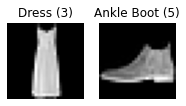

In [ ]:
''' Target classes '''

target1 = 3
target2 = 9

# Plotting a few examples

shirt_i = torch.where(yTest == target1)[0][0]
sneak_i = torch.where(yTest == target2)[0][0]
plt.figure(figsize=(3,2))
plt.subplot(1,2,1)
plt.imshow(XTest[shirt_i], cmap='gray')
plt.axis('off')
plt.title('Dress (3)')
plt.subplot(1,2,2)
plt.imshow(XTest[sneak_i], cmap='gray')
plt.axis('off')
plt.title('Ankle Boot (5)');

# Remove all other classes from data

target_labels = (yTest == target1) | (yTest == target2)

XTest = XTest[target_labels]
yTest = yTest[target_labels]

### *D1.A: Applying PCA*

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=30)
pca.fit(XTest.view(-1, 28*28));

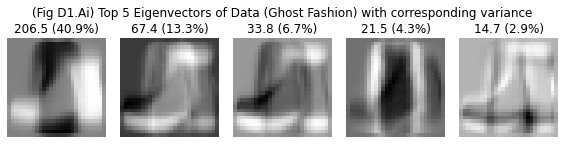

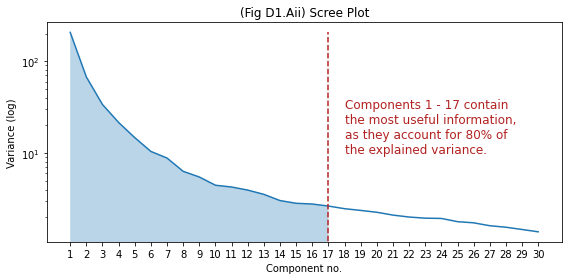

In [ ]:
plt.figure(figsize=(8,2), tight_layout=True)
plt.suptitle('(Fig D1.Ai) Top 5 Eigenvectors of Data (Ghost Fashion) with corresponding variance')
top5components = pca.components_[:5]
top5variance = pca.explained_variance_[:5]
top5ratio = pca.explained_variance_ratio_[:5]
for i in range(5):
    img = top5components[i].reshape(28, 28)
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title('{:.1f} ({:.1f}%)'.format(top5variance[i], top5ratio[i]*100))
    plt.axis('off')
plt.show()

cumratio = np.cumsum(pca.explained_variance_ratio_)
capratio = np.where(cumratio < 0.8)[0] # Components which account for < 80% of the variance
capcomp = capratio[-1]

plt.figure(figsize=(8,4), tight_layout=True)
plt.plot(pca.explained_variance_)
plt.vlines(capcomp, 0, pca.explained_variance_.max(), linestyles='dashed', color='firebrick')
plt.fill_between(np.arange(capcomp+1), pca.explained_variance_[:capcomp+1], alpha=0.3)

plt.yscale('log')
plt.title('(Fig D1.Aii) Scree Plot')
plt.xticks(np.arange(30), np.arange(1,31))
plt.ylabel('Variance (log)')
plt.xlabel('Component no.');
label = '''Components 1 - {} contain
the most useful information, 
as they account for 80% of 
the explained variance.'''.format(capcomp+1)

plt.annotate(label, (17, 10), color='firebrick', fontsize=12);

### *D1.B: Reconstructing Images*

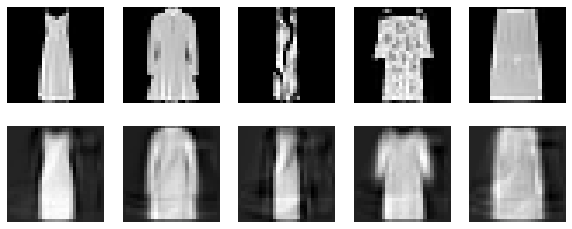

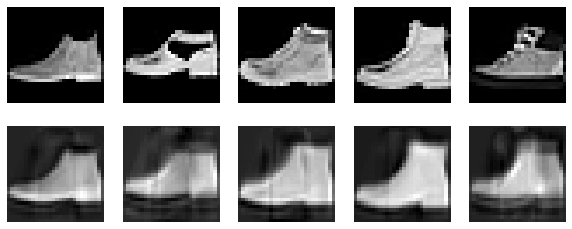

In [ ]:
Z = pca.fit_transform(XTest.reshape(-1, 28*28)) # Projected Principal components for each sample

shirt_indxs = torch.where(yTest == target1)[0]
shoes_indxs = torch.where(yTest == target2)[0]

def show_reconstructions(class_indices):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        indx = class_indices[i]
        XTrue = XTest[indx]
        XRec = Z[indx] @ pca.components_ + pca.mean_
        plt.subplot(2,5,i+1)
        plt.imshow(XTrue, cmap='gray')
        plt.axis('off')
        plt.subplot(2,5,i+6)
        plt.imshow(XRec.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

show_reconstructions(shirt_indxs)
show_reconstructions(shoes_indxs)

### *D1.C: Plotting Top-Two Principal Components*

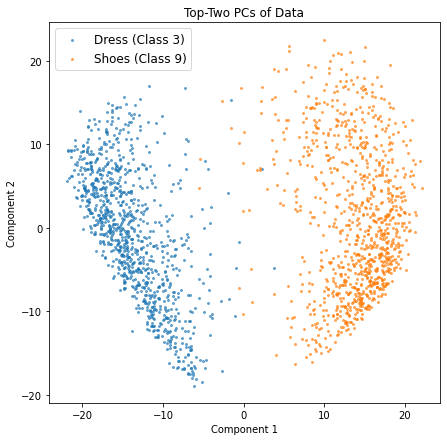

In [ ]:
top2c = Z[:, :2]

plt.figure(figsize=(7,7))
plt.scatter(top2c[:, 0][shirt_indxs], top2c[:, 1][shirt_indxs], alpha=0.6, s=4)
plt.scatter(top2c[:, 0][shoes_indxs], top2c[:, 1][shoes_indxs], alpha=0.6, s=4)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Top-Two PCs of Data');

plt.legend(['Dress (Class 3)', 'Shoes (Class 9)'], fontsize=12);

### *D1.D: Using Spectral Clustering to Cluster Top-Two Components*

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
clustering = SpectralClustering(n_clusters=2, n_jobs=-1)
labels = clustering.fit_predict(Z[:, :2])

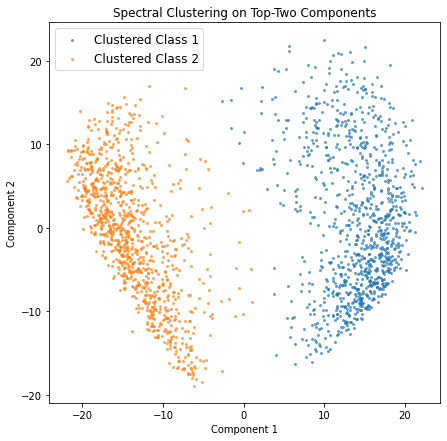

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(top2c[:, 0][labels==0], top2c[:, 1][labels==0], alpha=0.6, s=4)
plt.scatter(top2c[:, 0][labels==1], top2c[:, 1][labels==1], alpha=0.6, s=4)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Spectral Clustering on Top-Two Components');

plt.legend(['Clustered Class 1', 'Clustered Class 2'], fontsize=12);

### *D1.E: Designing an Autoencoder*

In [ ]:
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 2, padding=1),           # 16 x 29 x 29
            nn.ReLU(),
            nn.Conv2d(16, 16, 2, padding=1),          # 16 x 30 x 30
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),          # 16 x 30 x 30
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2),             # 32 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 64 x 7 x 7
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### *Training the Autoencoder*

In [ ]:
# Create dataloader

BATCH_SIZE = 128

test_set = list(zip(XTest, XTest)) # Labels are true images.
test_loader = data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)


# Train the autoencoder

lr = 1e-2
n_epochs = 20

model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

losses = []

for i in tqdm(range(n_epochs)):
    for inputs, targets in test_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs.unsqueeze(1))
        
        loss = criterion(outputs, targets.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
    # Track Convergence
    outputs = model(XTest.unsqueeze(1))
    loss = criterion(outputs, XTest.unsqueeze(1))
    losses.append(loss.item())

100%|██████████| 20/20 [02:53<00:00,  8.69s/it]


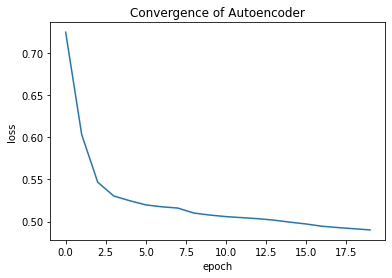

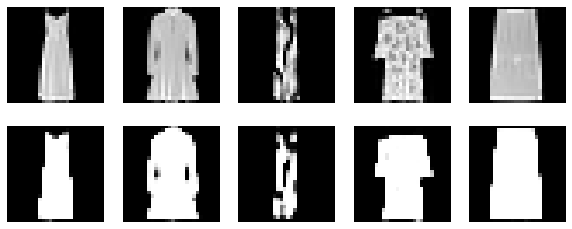

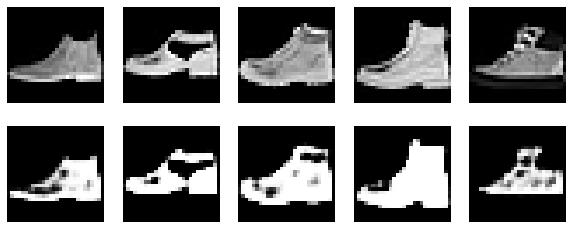

In [ ]:
''' Plotting Loss against Epoch '''
plt.title('Convergence of Autoencoder')
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

''' Reconstructing on images '''

def show_autoencoder_reconstructions(class_indices):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        indx = class_indices[i]
        XTrue = XTest[indx]
        XRec = model(XTrue.view(1, 1, 28, 28)).detach().numpy()
        plt.subplot(2,5,i+1)
        plt.imshow(XTrue, cmap='gray')
        plt.axis('off')
        plt.subplot(2,5,i+6)
        plt.imshow(XRec.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

show_autoencoder_reconstructions(shirt_indxs)
show_autoencoder_reconstructions(shoes_indxs)

**Observations**
* From the Scree plot at figure (D1.Aii), it is shown that PCA analysis projects the top 17 components into lower-dimensional features of high variance, and that selecting features from this subset results in highly seperable data$^1$.
* In section D1.E, we show how the Autoencoder reconstructs images after training. It appears that the encoder was able to capture the general structure of the image, only losing fine detail in the image itself$^2$.  